# draft 20220209

To avoid git conflict with others modification, I create a new notebook with most code copied from the previous one `load_data.ipynb`

TLDR

1. code below takes less than 5 minutes to finish.
2. `anti_alising=True` improve score greatly for both QSVM and QNN
3. different `resize_image_size` (equivalently number of qubits) helps a little bit, but not remarkable. 
4. no large difference between `QSVM` and `QNN` results
5. results with different parameter need only one line of code (see `QSVM/QNN all in one` section), please try it

**reminder** to run the code quickly, remember to set `class_size=24` in `load_data` section. `class_size=240` might spend several hours.

TODO (but time maybe not enough)

1. real quantum computer device?
2. `class_size=240`
3. other labels: `alpha`, `beta`, etc.

Table of Content

1. how `skimage.transform.resize` works
   * `skimage.transform.resize` on 1-d image
   * `skimage.transform.resize` on 2-d image
2. load data
   * plot part of images and resized images
   * select training set and test set
3. quantum SVM (QSVM) model
4. QSVM all in one
   * compare `anti_alising=True` and `anti_alising=False`
   * compare `resize_image_size`
5. quantum Neural Network (QNN) model
6. QNN all in one
   * compare `anti_alising=True` and `anti_alising=False`
   * compare `resize_image_size`

In [1]:
import os
import glob
import json
import hashlib
import PIL.Image
import numpy as np
import matplotlib
import matplotlib.patches
import matplotlib.pyplot as plt

import skimage
import sklearn.model_selection
import sklearn.svm

import concurrent.futures
import qiskit
import qiskit.providers.aer
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, TwoLocal
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

## how `skimage.transform.resize` works

TLDR

1. `skimage.transform.resize()` is the bilinear interpolation scheme [wiki](https://en.wikipedia.org/wiki/Bilinear_interpolation)
2. `skimage.transform.resize(anti_aliasing=False)` might be not good as `skimage.transform.resize(anti_aliasing=True)` with a suitable `anti_aliasing_sigma` value, since the former only use **part of** pixels (roughly 4 pixels) of the whole image
3. when `skimage.transform.resize(anti_aliasing=True, anti_aliasing_sigma=xxx)`, default value for `anti_aliasing_sigma` is `(s-1)/2` where `s` is the downsampling factor, see [skimage-doc](https://scikit-image.org/docs/dev/api/skimage.transform.html#resize). `anti_aliasing_sigma` controls the Gaussian filter

### `skimage.transform.resize` on 1-d image

resize `(height=1,width=8)` image to `(height=1,width=2)`. In the figure below, 8 blue points represents a `(height=1,width=8)` image (the pixel position), 2 orange points represents a `(height=1,width=2)` image that downsampling from `(height=1,width=8)` image.

when `anti_aliasing=False`, only the 4 points in red boxes make contribution to the downsampled image, points in the left (right) box contribute to the left (right) pixel by some linear combinations.

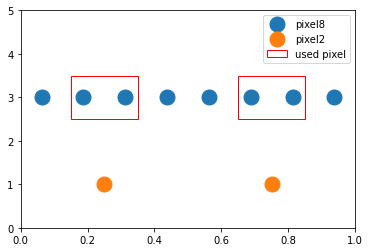

In [2]:
# downsample (height=1,width=8) image to (height=1,width=2) image
hf0 = lambda x: np.arange(1, 2*x, 2)/(2*x)
pixel8 = hf0(8)
pixel2 = hf0(2)

fig,ax = plt.subplots()
ax.plot(pixel8, np.ones_like(pixel8)*3, '.', markersize=30, label='pixel8')
ax.plot(pixel2, np.ones_like(pixel2)*1, '.', markersize=30, label='pixel2')
ax.add_patch(matplotlib.patches.Rectangle((0.15,2.5),height=1,width=0.2,fill=False,color='r',label='used pixel'))
ax.add_patch(matplotlib.patches.Rectangle((0.65,2.5),height=1,width=0.2,fill=False,color='r'))
ax.legend()
ax.set_xlim(0,1)
_ = ax.set_ylim(0, 5)

In [3]:
# randomly generate a (height=1,width=8) image (image_pixel8), and modified one unused pixel (image_pixel8_modified)
# downsampling two images above with anti_aliasing=False will get exactly the same results, image_pixel2 and image_pixel2_modified,
# which means that pixel has no contribution.
# you can also try anti_aliasing=True, then almost all pixels should have contribution
anti_aliasing = False

image_pixel8 = np.random.rand(1, 8)
image_pixel2 = skimage.transform.resize(image_pixel8, (1, 2), order=1, anti_aliasing=anti_aliasing)

image_pixel8_modified = image_pixel8.copy()
image_pixel8_modified[0,0] = np.random.rand() #replace one unused pixel (pixel-0) to a random value
image_pixel2_modified = skimage.transform.resize(image_pixel8_modified, (1, 2), order=1, anti_aliasing=anti_aliasing)

np.set_printoptions(precision=4, linewidth=220)
print('image_pixel8:', image_pixel8)
print('image_pixel2:', image_pixel2)
print('image_pixel8_modified:', image_pixel8_modified)
print('image_pixel2_modified:', image_pixel2_modified) #should be the same as image_pixel2 when anti_aliasing=False

image_pixel8: [[0.5193 0.0373 0.1042 0.6052 0.1514 0.6837 0.6324 0.5045]]
image_pixel2: [[0.0707 0.6581]]
image_pixel8_modified: [[0.7303 0.0373 0.1042 0.6052 0.1514 0.6837 0.6324 0.5045]]
image_pixel2_modified: [[0.0707 0.6581]]


### `skimage.transform.resize` on 2-d image

resize `(height=8,width=8)` image to `(height=2,width=2)`

In [4]:
anti_aliasing = False

image_pixel8 = np.random.rand(8, 8)
image_pixel2 = skimage.transform.resize(image_pixel8, (2, 2), order=1, anti_aliasing=anti_aliasing)

image_pixel8_modified = image_pixel8.copy()
image_pixel8_modified[0,0] = np.random.rand() #replace one unused pixel (pixel-0) to a random value
image_pixel2_modified = skimage.transform.resize(image_pixel8_modified, (2, 2), order=1, anti_aliasing=anti_aliasing)

np.set_printoptions(precision=4, linewidth=220)
# print('image_pixel8:', image_pixel8)
print('image_pixel2:\n', image_pixel2)
# print('image_pixel8_modified:', image_pixel8_modified)
print('image_pixel2_modified:\n', image_pixel2_modified) #should be the same as image_pixel2 when anti_aliasing=False

image_pixel2:
 [[0.6141 0.3825]
 [0.5852 0.5303]]
image_pixel2_modified:
 [[0.6141 0.3825]
 [0.5852 0.5303]]


## load data

download dataset from kaggle [https://www.kaggle.com/xainano/handwrittenmathsymbols](https://www.kaggle.com/xainano/handwrittenmathsymbols) (a large `rar` file within `zip` file), and extract the images. The folder structure should be similar as below

```bash
Team-3-Quantum-Hackers-Project/
├── README.md
├── LICENSE
├── .gitignore
├── load_data.ipynb
└── extracted_images/
    ├── 0/
    |   ├── 0_100070.jpg
    |   ├── 0_100080.jpg
    |   ├── 0_100081.jpg
    |   └── ...
    ├── 1/
    ├── !/
    ├── (/
    ├── )/
    └── ...
```

In [5]:
# get filepath and label of all images
datadir = 'extracted_images'
all_label = os.listdir(datadir)
all_image_path = {x:[os.path.join(datadir,x,y) for y in os.listdir(os.path.join(datadir,x))] for x in all_label}

print('all label:', all_label)
print('some image path:')
for x in list(all_image_path.keys())[:4]:
    print(x, all_image_path[x][:2])

all label: ['beta', 'infty', 'cos', '6', '0', 'prime', '=', 'gt', 'o', 'lt', 'y', 'b', '!', 'T', 'C', 'leq', 'R', 'exists', 'p', 'N', '3', '{', 'H', 'z', 'ascii_124', 'alpha', 'sigma', '9', 'int', 'q', 'l', 'lambda', 'A', 'theta', '2', 'S', '5', 'sqrt', '7', 'sum', '4', 'v', 'e', 'M', 'forall', 'j', '-', ')', '1', 'w', '(', 'phi', 'i', ',', 'lim', 'Delta', 'G', '8', 'u', 'k', 'rightarrow', 'div', 'neq', '[', 'pi', ']', 'f', 'geq', 'pm', 'forward_slash', 'gamma', '}', 'X', '+', 'times', 'log', 'tan', 'd', 'in', 'sin', 'ldots', 'mu']
some image path:
beta ['extracted_images/beta/beta_57145.jpg', 'extracted_images/beta/exp26500.jpg']
infty ['extracted_images/infty/exp96368.jpg', 'extracted_images/infty/exp78043.jpg']
cos ['extracted_images/cos/exp48148.jpg', 'extracted_images/cos/exp91430.jpg']
6 ['extracted_images/6/exp22030.jpg', 'extracted_images/6/6_56393.jpg']


### Plot parts of images and resized images

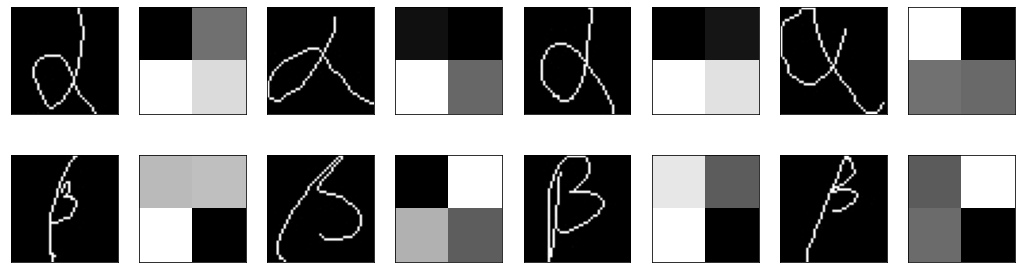

In [63]:
# hyper-parameter, modify below to see the effects
plot_label_list = ['alpha', 'beta']# ['0', '1', 'alpha', 'beta']
num_column = 4
resize_image_size = 2,2
anti_aliasing = True
anti_aliasing_sigma = None #default to (s-1)/2 where s=45/2 is the downsamplign factor

# plot function
fig, ax_list = plt.subplots(nrows=len(plot_label_list), ncols=2*num_column, figsize=(18, 5))
for i in range(len(plot_label_list)):
    image_list = all_image_path[plot_label_list[i]]
    random_index = np.random.choice(np.arange(len(image_list)), size=num_column)
    for j in range(num_column):
        path = image_list[random_index[j]]
        image = np.array(PIL.Image.open(path))
        image_small = skimage.transform.resize(image, resize_image_size,
                           anti_aliasing=anti_aliasing, anti_aliasing_sigma=anti_aliasing_sigma)
        ax_list[i,2*j].imshow(image, cmap=plt.cm.gray_r)
        ax_list[i,2*j].set_xticks([])
        ax_list[i,2*j].set_yticks([])
        ax_list[i,2*j+1].imshow(image_small, cmap=plt.cm.gray_r)
        ax_list[i,2*j+1].set_xticks([])
        ax_list[i,2*j+1].set_yticks([])
# fig.savefig('fig/draft20220209/sample-image.png', dpi=100)

### select training set and test set

1. select label
2. select part of the data, otherwise itt takes too long to train on the whole dataset
3. split train and test set

In [16]:
# hyper-parameter, you can modify it to choose different label, etc.
seed = 42 #to fix the result, change it to seed=23 or some other integer or None
labels = ['alpha', 'beta'] #binary classification
label_to_int = {labels[0]:0, labels[1]:1}
#class_size=240 will take roughly half an hour to train, class_size=24 will take roughly 1 minutes
class_size = 100

data_list = []
label_list = []
for x in labels:
    image_list = all_image_path[x]
    random_index = np.random.choice(np.arange(len(image_list)), size=class_size)
    for i in random_index:
        path = image_list[i]
        data_list.append(np.array(PIL.Image.open(image_list[i])))
        label_list.append(label_to_int[x])

# data_list = [skimage.transform.resize(x, resize_image_size, anti_aliasing=False).reshape(-1) for x in data_list]
data_list = np.stack(data_list)/255 #normalized to [0,1]
label_list = np.array(label_list)
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
            data_list, label_list, test_size=0.2, shuffle=True, random_state=seed)
print('x_train include {} images, each of size ({},{}), range from {} to {}'.format(*x_train.shape, x_train.min(), x_train.max()))
print('x_test include {} images, each of size ({},{}), range from {} to {}'.format(*x_test.shape, x_test.min(), x_test.max()))

x_train include 160 images, each of size (45,45), range from 0.0 to 1.0
x_test include 40 images, each of size (45,45), range from 0.0 to 1.0


auxiliary function to save and load result

since training time is quite long, we can save the computed result and load it next time.

## misc function

In [8]:
import qiskit.providers.ibmq

# save ibmq_token from ibmq website to ~/qiskit_token.txt
with open(os.path.expanduser('~/qiskit_token.txt'), 'r') as fid:
    IBMQ_TOKEN = fid.read().strip()
if 'ibmq_provider' not in locals():
    # ibmq_provider = qiskit.providers.ibmq.IBMQ.enable_account(IBMQ_TOKEN, group='open', hub='ibm-q', project='main')
    ibmq_provider = qiskit.providers.ibmq.IBMQ.enable_account(IBMQ_TOKEN,
                                  group='qscitech-quantum', hub='ibm-q-education', project='qc-bc-workshop')
ibmq_jakarta = ibmq_provider.get_backend('ibmq_jakarta')
qiskit.visualization.plot_error_map(ibmq_jakarta)
qi_ibmq = qiskit.utils.QuantumInstance(ibmq_jakarta, shots=1024) #initial_layout=[4,]

In [14]:
RESULT_DIR = 'result'

def save_result(param, **kwargs):
    param['class_size'] = class_size #number of sample per label
    param['labels'] = labels
    if not os.path.exists(RESULT_DIR):
        os.makedirs(RESULT_DIR)
    tmp0 = json.dumps(param)
    filename = int(hashlib.sha1(tmp0.encode("utf-8")).hexdigest(), 16) % (10 ** 8) #use hash as filename
    filepath = os.path.join(RESULT_DIR, f'{filename}.json')
    for key,value in kwargs.items():
        if isinstance(value,np.ndarray):
            kwargs[key] = value.tolist()
    kwargs['param'] = param
    with open(filepath, 'w', encoding='utf-8') as fid:
        json.dump(kwargs, fid, indent=4)
    print(f'result saved to "{filepath}"')
    return filepath


def load_result(hashkey):
    filepath = os.path.join(RESULT_DIR, f'{hashkey}.json')
    assert os.path.exists(filepath)
    with open(filepath, 'r', encoding='utf-8') as fid:
        ret = json.load(fid)
    param = ret.pop('param')
    return param, ret

### FRQI featuremap [link](https://qiskit.org/textbook/ch-applications/image-processing-frqi-neqr.html#2.-Building-the-FRQI-State:-A-Two-Step-Process)

In [10]:
def frqi_state(feature_dim):
    assert feature_dim==4
    qc = qiskit.QuantumCircuit(feature_dim)
    theta = qiskit.circuit.ParameterVector('theta', feature_dim)
        
    qc.h(0)
    qc.h(1)

    qc.barrier()
    #Pixel 1

    qc.cry(theta[0],0,2)
    qc.cx(0,1)
    qc.cry(-theta[0],1,2)
    qc.cx(0,1)
    qc.cry(theta[0],1,2)

    qc.barrier()
    #Pixel 2

    qc.x(1)
    qc.cry(theta[1],0,2)
    qc.cx(0,1)
    qc.cry(-theta[1],1,2)
    qc.cx(0,1)
    qc.cry(theta[1],1,2)
    qc.x(1)

    qc.barrier()

#     qc.x(1)
    qc.x(0)
    qc.cry(theta[2],0,2)
    qc.cx(0,1)
    qc.cry(-theta[2],1,2)
    qc.cx(0,1)
    qc.cry(theta[2],1,2)
    qc.x(0)

    qc.barrier()

    qc.x(1)
    qc.x(0)
    qc.cry(theta[3],0,2)
    qc.cx(0,1)
    qc.cry(-theta[3],1,2)
    qc.cx(0,1)
    qc.cry(theta[3],1,2)
    qc.x(1)
    qc.x(0)
    
    qc.barrier()
    
#     qc.h(0)
#     qc.h(1)

    return qc

## quantum SVM model

hyper-parameter

In [24]:
feature_dim = 4
resize_image_size = 2,2
anti_aliasing = True
anti_aliasing_sigma = None #default to (s-1)/2 where s=44/2 is the downsamplign factor
# normalize the data into range [normalize_min,normalize_max]
normalize_min = 0
normalize_max = 1
feature_type = 'ZZ' #Pauli or ZZ
# TODO amplitude encoding
feature_repeat = 2 #see ZZFeatureMap argument
qasm_shots = 1024
seed = None #random seed

# feature_dim should be the same as #pixel
assert resize_image_size[0]*resize_image_size[1]==feature_dim

resize and normalize

In [11]:
# resize x_train to resize_image_size, and scale it to range [normalize_min,normalize_max]
tmp0 = np.stack([skimage.transform.resize(x, resize_image_size,
                       anti_aliasing=anti_aliasing, anti_aliasing_sigma=anti_aliasing_sigma).reshape(-1) for x in x_train])
scale_a = (normalize_max-normalize_min)/(tmp0.max()-tmp0.min())
scale_b = normalize_min - tmp0.min()*scale_a
x_train_normed = tmp0*scale_a + scale_b

# resize x_test, and apply the same scale as x_train
tmp0 = np.stack([skimage.transform.resize(x, resize_image_size,
                       anti_aliasing=anti_aliasing, anti_aliasing_sigma=anti_aliasing_sigma).reshape(-1) for x in x_test])
x_test_normed = tmp0*scale_a + scale_b

# print the shape, range information
print('x_train_normed include {} images, each of shape ({}), range from {:.3f} to {:.3f}'.format(*x_train_normed.shape, x_train_normed.min(), x_train_normed.max()))
print('x_test_normed include {} images, each of shape ({}), range from {:.3f} to {:.3f}'.format(*x_test_normed.shape, x_test_normed.min(), x_test_normed.max()))

x_train_normed include 38 images, each of shape (4), range from 0.000 to 1.000
x_test_normed include 10 images, each of shape (4), range from 0.224 to 0.962


create a new quantum simulator, or we can replace it with a real quantum computer instance in the future.

In [12]:
aer_qasm_sim = qiskit.providers.aer.QasmSimulator()
qi_aer_qasm = qiskit.utils.QuantumInstance(aer_qasm_sim, shots=qasm_shots, seed_simulator=seed)

create `feature_map`, `feature_kernel`, and draw the circuit

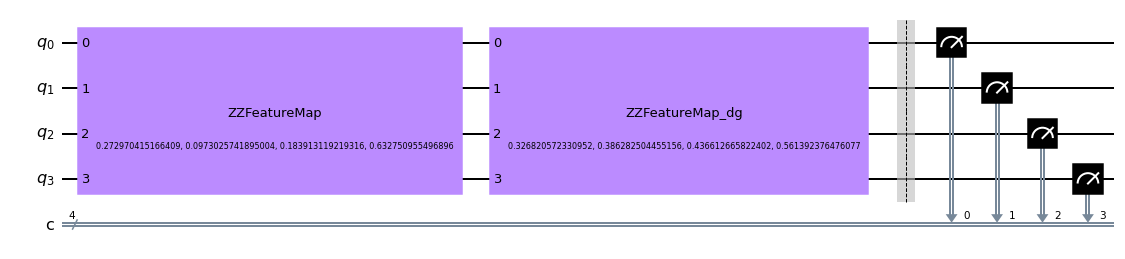

In [13]:
if feature_type=='ZZ':
    feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=feature_repeat, entanglement='linear')
else:
    feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=feature_repeat, entanglement='linear')
feature_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=qi_aer_qasm)

#Constructing the inner product circuit for given datapoints and feature map
feature_circuit = feature_kernel.construct_circuit(x_train_normed[0], x_train_normed[1])
feature_circuit.decompose().draw('mpl')

train and evaluate the model

In [14]:
# train quantum SVM model with train set
model = sklearn.svm.SVC(kernel= feature_kernel.evaluate)
model.fit(x_train_normed, y_train)

# evaluate QSVM using train set
accuracy = model.score(x_train_normed, y_train)
print(f'classification accuracy on train set (size={len(y_train)}): {accuracy}')

# evaluate QSVM using set set
accuracy = model.score(x_test_normed, y_test)
print(f'classification accuracy on test set (size={len(y_test)}): {accuracy}')

classification accuracy on train set (size=38): 1.0
classification accuracy on test set (size=10): 0.9


## QSVM all in one

Bundle all above in one code block, and run it with different hyper-parameter. Please go through the section above to get the meaning of the below code.

In [12]:
def QSVM_all_in_one(param:dict):
    param = dict(param) #make a copy
    # set default value
    param.setdefault('feature_dim', 4)
    param.setdefault('resize_image_size', (2,2))
    param.setdefault('anti_aliasing', True)
    #anti_aliasing_sigma default to (s-1)/2 where s=44/2 is the downsamplign factor
    param.setdefault('anti_aliasing_sigma', None)
    # normalize the data into range [normalize_min,normalize_max]
    param.setdefault('normalize_min', 0)
    param.setdefault('normalize_max', 1)
    param.setdefault('feature_type', 'ZZ') #ZZ or Pauli
    # TODO amplitude encoding
    param.setdefault('feature_repeat', 2) #see ZZFeatureMap argument
    param.setdefault('qasm_shots', 1024)
    param.setdefault('use_ibmq', False)
    param.setdefault('seed', None)
    
    feature_dim = param['feature_dim']
    resize_image_size = param['resize_image_size']
    anti_aliasing = param['anti_aliasing']
    anti_aliasing_sigma = param['anti_aliasing_sigma']
    normalize_min = param['normalize_min']
    normalize_max = param['normalize_max']
    feature_type = param['feature_type']
    feature_repeat = param['feature_repeat']
    qasm_shots = param['qasm_shots']
    seed = param['seed']
    use_ibmq = param['use_ibmq']

    # resize x_train to resize_image_size, and scale it to range [normalize_min,normalize_max]
    tmp0 = np.stack([skimage.transform.resize(x, resize_image_size,
                           anti_aliasing=anti_aliasing, anti_aliasing_sigma=anti_aliasing_sigma).reshape(-1) for x in x_train])
    scale_a = (normalize_max-normalize_min)/(tmp0.max()-tmp0.min())
    scale_b = normalize_min - tmp0.min()*scale_a
    x_train_normed = tmp0*scale_a + scale_b

    # resize x_test, and apply the same scale as x_train
    tmp0 = np.stack([skimage.transform.resize(x, resize_image_size,
                           anti_aliasing=anti_aliasing, anti_aliasing_sigma=anti_aliasing_sigma).reshape(-1) for x in x_test])
    x_test_normed = tmp0*scale_a + scale_b

    # print the shape, range information
    print('x_train_normed include {} images, each of shape ({}), range from {:.3f} to {:.3f}'.format(*x_train_normed.shape, x_train_normed.min(), x_train_normed.max()))
    print('x_test_normed include {} images, each of shape ({}), range from {:.3f} to {:.3f}'.format(*x_test_normed.shape, x_test_normed.min(), x_test_normed.max()))

    if use_ibmq:
        qinstance = qi_ibmq
    else:
        aer_qasm_sim = qiskit.providers.aer.QasmSimulator()
        qinstance = qiskit.utils.QuantumInstance(aer_qasm_sim, shots=qasm_shots, seed_simulator=seed)

    if feature_type=='ZZ':
        feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=feature_repeat, entanglement='linear')
    elif feature_type=='Pauli':
        feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=feature_repeat, entanglement='linear')
    elif feature_type=='FRQI':
        feature_map = frqi_state(feature_dim)
    else:
        assert False, 'unknown feature_type'
    feature_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=qinstance)

    # train quantum SVM model with train set
    model = sklearn.svm.SVC(kernel= feature_kernel.evaluate)
    model.fit(x_train_normed, y_train)

    train_accuracy = model.score(x_train_normed, y_train)
    print(f'classification accuracy on train set (size={len(y_train)}): {train_accuracy}')

    test_accuracy = model.score(x_test_normed, y_test)
    print(f'classification accuracy on test set (size={len(y_test)}): {test_accuracy}')
    return param,train_accuracy,test_accuracy


### run on real device

In [ ]:
param = {'anti_aliasing':True, 'feature_dim':2, 'resize_image_size':(1,2), 'use_ibmq':True}
param, train_accuracy, test_accuracy = QSVM_all_in_one(param)

### compare `anti_aliasing=True` and `anti_aliasing=False`

`class_size=100` (total `200` samples)

| `anti_aliasing` | train-accuracy | test-accuracy |
| :-: | :-: | :-: |
| `True` | `0.962` | `0.775` |
| `False` | `0.706` | `0.55` |

conclusion: `anti_aliasing=True` is much better than `anti_aliasing=False`

In [17]:
param = {'anti_aliasing':True, 'seed':None}
param,train_accuracy,test_accuracy = QSVM_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy)

param = {'anti_aliasing':False, 'seed':None}
param,train_accuracy,test_accuracy = QSVM_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy)

x_train_normed include 160 images, each of shape (4), range from 0.000 to 1.000
x_test_normed include 40 images, each of shape (4), range from 0.236 to 1.024
classification accuracy on train set (size=160): 0.9625
classification accuracy on test set (size=40): 0.775
result saved to "result/40863742.json"
x_train_normed include 160 images, each of shape (4), range from 0.000 to 1.000
x_test_normed include 40 images, each of shape (4), range from -0.232 to 1.000
classification accuracy on train set (size=160): 0.70625
classification accuracy on test set (size=40): 0.55
result saved to "result/5696228.json"


'result/5696228.json'

### compare `resize_image_size`

number of qubit is equal to `#qubits=height*width`. **more qubits help**

`class_size=100` (total `200` samples)

| `resize_image_size` | train-accuracy | test-accuracy |
| :-: | :-: | :-: |
| `(1,2)` | `0.669` | `0.6` |
| `(2,1)` | `0.825` | `0.75` |
| `(2,2)` | `0.956` | `0.8` |
| `(3,3)` | `1.0` | `0.925` |

In [18]:
param = {'anti_aliasing':True, 'feature_dim':2, 'resize_image_size':(1,2)}
param, train_accuracy, test_accuracy = QSVM_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy)

param = {'anti_aliasing':True, 'feature_dim':2, 'resize_image_size':(2,1)}
param, train_accuracy, test_accuracy = QSVM_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy)

param = {'anti_aliasing':True, 'feature_dim':4, 'resize_image_size':(2,2)}
param, train_accuracy, test_accuracy = QSVM_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy)

param = {'anti_aliasing':True, 'feature_dim':9, 'resize_image_size':(3,3)}
param, train_accuracy, test_accuracy = QSVM_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy)

x_train_normed include 160 images, each of shape (2), range from 0.000 to 1.000
x_test_normed include 40 images, each of shape (2), range from 0.181 to 0.985
classification accuracy on train set (size=160): 0.66875
classification accuracy on test set (size=40): 0.6
result saved to "result/9616005.json"
x_train_normed include 160 images, each of shape (2), range from 0.000 to 1.000
x_test_normed include 40 images, each of shape (2), range from 0.307 to 0.992
classification accuracy on train set (size=160): 0.825
classification accuracy on test set (size=40): 0.75
result saved to "result/46677867.json"
x_train_normed include 160 images, each of shape (4), range from 0.000 to 1.000
x_test_normed include 40 images, each of shape (4), range from 0.236 to 1.024
classification accuracy on train set (size=160): 0.95625
classification accuracy on test set (size=40): 0.8
result saved to "result/9344539.json"
x_train_normed include 160 images, each of shape (9), range from 0.000 to 1.000
x_test_n

'result/37066671.json'

### compare `ZZFeatureMap`, `Pauli`, `FRQI`

In [20]:
param = {'anti_aliasing':True, 'feature_type':'ZZ'}
param, train_accuracy, test_accuracy = QSVM_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy)

param = {'anti_aliasing':True, 'feature_type':'FRQI'}
param, train_accuracy, test_accuracy = QSVM_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy)

param = {'anti_aliasing':True, 'feature_type':'Pauli'}
param, train_accuracy, test_accuracy = QSVM_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy)

x_train_normed include 160 images, each of shape (4), range from 0.000 to 1.000
x_test_normed include 40 images, each of shape (4), range from 0.236 to 1.024
classification accuracy on train set (size=160): 0.95625
classification accuracy on test set (size=40): 0.8
result saved to "result/51992678.json"
x_train_normed include 160 images, each of shape (4), range from 0.000 to 1.000
x_test_normed include 40 images, each of shape (4), range from 0.236 to 1.024
classification accuracy on train set (size=160): 0.9125
classification accuracy on test set (size=40): 0.8
result saved to "result/41374090.json"
x_train_normed include 160 images, each of shape (4), range from 0.000 to 1.000
x_test_normed include 40 images, each of shape (4), range from 0.236 to 1.024
classification accuracy on train set (size=160): 0.96875
classification accuracy on test set (size=40): 0.8
result saved to "result/38276342.json"


'result/38276342.json'

## quantum neural network (QNN) model

auxiliary functions

In [23]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

def callback_wrapper(loss_recorder:list):
    def callback(nfev, params, fval, stepsize, accepted=None):
        """
        Can be used for SPSA and GradientDescent optimizers
        nfev: the number of function evals
        params: the current parameters
        fval: the current function value
        stepsize: size of the update step
        accepted: whether the step was accepted (not used for )
        """
        loss_recorder.append(fval)
        if nfev%21==0: #print less
            print(f'{nfev} - {fval}')
    return callback

def get_one_hot_encoding(y):
    N0 = len(y)
    ret = np.zeros((N0,2), dtype=np.int64)
    ret[np.arange(N0), y] = 1
    return ret

hyper-parameter. modify this code block, and run the following code blocks

In [28]:
feature_dim = 4
resize_image_size = 2,2
anti_aliasing = True
anti_aliasing_sigma = None #default to (s-1)/2 where s=44/2 is the downsamplign factor
# normalize the data into range [normalize_min,normalize_max]
normalize_min = 0
normalize_max = 1
feature_type = 'ZZ' #Pauli or ZZ
# TODO amplitude encoding
feature_repeat = 2 #see ZZFeatureMap argument
ansatz_repeat = 2 #see TwoLocal argument
qasm_shots = 1024
seed = None #random seed
maxiter = 100

# feature_dim should be the same as #pixel
assert resize_image_size[0]*resize_image_size[1]==feature_dim

np_rng = np.random.default_rng(seed)

resize, normalize, one-hot coding

In [30]:
# resize x_train to resize_image_size, and scale it to range [normalize_min,normalize_max]
tmp0 = np.stack([skimage.transform.resize(x, resize_image_size,
                       anti_aliasing=anti_aliasing, anti_aliasing_sigma=anti_aliasing_sigma).reshape(-1) for x in x_train])
scale_a = (normalize_max-normalize_min)/(tmp0.max()-tmp0.min())
scale_b = normalize_min - tmp0.min()*scale_a
x_train_normed = tmp0*scale_a + scale_b

y_train_1h = get_one_hot_encoding(y_train)

# resize x_test, and apply the same scale as x_train
tmp0 = np.stack([skimage.transform.resize(x, resize_image_size,
                       anti_aliasing=anti_aliasing, anti_aliasing_sigma=anti_aliasing_sigma).reshape(-1) for x in x_test])
x_test_normed = tmp0*scale_a + scale_b

y_test_1h = get_one_hot_encoding(y_test)

# print the shape, range information
print('x_train_normed include {} images, each of shape ({}), range from {:.3f} to {:.3f}'.format(*x_train_normed.shape, x_train_normed.min(), x_train_normed.max()))
print('x_test_normed include {} images, each of shape ({}), range from {:.3f} to {:.3f}'.format(*x_test_normed.shape, x_test_normed.min(), x_test_normed.max()))

x_train_normed include 38 images, each of shape (4), range from 0.000 to 1.000
x_test_normed include 10 images, each of shape (4), range from 0.354 to 1.009


create a new quantum simulator, or we can replace it with a real quantum computer instance in the future.

In [ ]:
aer_qasm_sim = qiskit.providers.aer.QasmSimulator()
qi_aer_qasm = qiskit.utils.QuantumInstance(aer_qasm_sim, shots=qasm_shots, seed_simulator=seed)

feature encoding circuit (without trainable parameters)

In [ ]:
if feature_type=='ZZ':
    feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=feature_repeat, entanglement='linear')
else:
    feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=feature_repeat, entanglement='linear')
feature_map.decompose().draw('mpl', scale=0.7)

ansatz circuit (with trainable parameters)

In [ ]:
ansatz = TwoLocal(num_qubits=feature_dim, rotation_blocks=['ry', 'rz'],
                         entanglement_blocks='cx', entanglement='linear', reps=ansatz_repeat)
ansatz.bind_parameters(np.zeros(len(ansatz.parameters)))
ansatz.decompose().draw('mpl', scale=0.7)

combine feature map circuit and ansatz circuit to make a quantum neural network

In [ ]:
qnn_circuit = feature_map.compose(ansatz)
num_classes = 2

qnn = CircuitQNN(circuit=qnn_circuit,
                 input_params=feature_map.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qi_aer_qasm)

loss_recorder = []
spsa_opt = SPSA(maxiter=maxiter, callback=callback_wrapper(loss_recorder))
initial_point = np_rng.uniform(0,2*np.pi,size=len(ansatz.parameters))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)

train and evalute the QNN model

In [ ]:
# train using train set
vqc.fit(x_train_normed, y_train_1h)

# evaluate on the train set and test set
train_accuracy = vqc.score(x_train_normed, y_train_1h)
test_accuracy = vqc.score(x_test_normed, y_test_1h)
print(f'accuracy on the train set (size={len(x_train)}): {train_accuracy}')
print(f'accuracy on the test set (size={len(x_test)}) {test_accuracy}')

# plot the loss curve
plt.plot(loss_recorder)

## QNN all in one

Bundle all above in one code block, and run it with different hyper-parameter. Please go through the section above to get the meaning of the below code.

In [21]:
def QNN_all_in_one(param):
    param = dict(param) #make a copy
    # set default value
    param.setdefault('feature_dim', 4)
    param.setdefault('resize_image_size', (2,2))
    param.setdefault('anti_aliasing', True)
    #anti_aliasing_sigma default to (s-1)/2 where s=44/2 is the downsamplign factor
    param.setdefault('anti_aliasing_sigma', None)
    # normalize the data into range [normalize_min,normalize_max]
    param.setdefault('normalize_min', 0)
    param.setdefault('normalize_max', 1)
    param.setdefault('feature_type', 'ZZ') #ZZ or Pauli
    # TODO amplitude encoding
    param.setdefault('feature_repeat', 2) #see ZZFeatureMap argument
    param.setdefault('ansatz_repeat', 2) #see TwoLocal argument
    param.setdefault('qasm_shots', 1024)
    param.setdefault('use_ibmq', False)
    param.setdefault('maxiter', 100)
    param.setdefault('seed', None)
    
    feature_dim = param['feature_dim']
    resize_image_size = param['resize_image_size']
    anti_aliasing = param['anti_aliasing']
    anti_aliasing_sigma = param['anti_aliasing_sigma']
    normalize_min = param['normalize_min']
    normalize_max = param['normalize_max']
    feature_type = param['feature_type']
    feature_repeat = param['feature_repeat']
    ansatz_repeat = param['ansatz_repeat']
    qasm_shots = param['qasm_shots']
    use_ibmq = param['use_ibmq']
    maxiter = param['maxiter']
    seed = param['seed']
    np_rng = np.random.default_rng(seed)

    # resize x_train to resize_image_size, and scale it to range [normalize_min,normalize_max]
    tmp0 = np.stack([skimage.transform.resize(x, resize_image_size,
                           anti_aliasing=anti_aliasing, anti_aliasing_sigma=anti_aliasing_sigma).reshape(-1) for x in x_train])
    scale_a = (normalize_max-normalize_min)/(tmp0.max()-tmp0.min())
    scale_b = normalize_min - tmp0.min()*scale_a
    x_train_normed = tmp0*scale_a + scale_b

    y_train_1h = get_one_hot_encoding(y_train)

    # resize x_test, and apply the same scale as x_train
    tmp0 = np.stack([skimage.transform.resize(x, resize_image_size,
                           anti_aliasing=anti_aliasing, anti_aliasing_sigma=anti_aliasing_sigma).reshape(-1) for x in x_test])
    x_test_normed = tmp0*scale_a + scale_b

    y_test_1h = get_one_hot_encoding(y_test)

    # print the shape, range information
    print('x_train_normed include {} images, each of shape ({}), range from {:.3f} to {:.3f}'.format(*x_train_normed.shape, x_train_normed.min(), x_train_normed.max()))
    print('x_test_normed include {} images, each of shape ({}), range from {:.3f} to {:.3f}'.format(*x_test_normed.shape, x_test_normed.min(), x_test_normed.max()))

    if use_ibmq:
        qinstance = qi_ibmq
    else:
        aer_qasm_sim = qiskit.providers.aer.QasmSimulator()
        qinstance = qiskit.utils.QuantumInstance(aer_qasm_sim, shots=qasm_shots, seed_simulator=seed)

    if feature_type=='ZZ':
        feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=feature_repeat, entanglement='linear')
    elif feature_type=='Pauli':
        feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=feature_repeat, entanglement='linear')
    elif feature_type=='FRQI':
        feature_map = frqi_state(feature_dim)
    else:
        assert False, 'unknown feature_type'
    ansatz = TwoLocal(num_qubits=feature_dim, rotation_blocks=['ry', 'rz'],
                     entanglement_blocks='cx', entanglement='linear', reps=ansatz_repeat)

    qnn_circuit = feature_map.compose(ansatz)
    num_classes = 2
    qnn = CircuitQNN(circuit=qnn_circuit, input_params=feature_map.parameters, weight_params=ansatz.parameters,
                interpret=one_qubit_binary, output_shape=num_classes, gradient=None, quantum_instance=qinstance)

    loss_recorder = []
    spsa_opt = SPSA(maxiter=maxiter, callback=callback_wrapper(loss_recorder))
    initial_point = np_rng.uniform(0,2*np.pi,size=len(ansatz.parameters))
    vqc = NeuralNetworkClassifier(neural_network=qnn, loss=CrossEntropyLoss(),
                              one_hot=True, optimizer=spsa_opt, initial_point=initial_point)

    # train using train set
    vqc.fit(x_train_normed, y_train_1h)

    # evaluate on the train set and test set
    train_accuracy = vqc.score(x_train_normed, y_train_1h)
    test_accuracy = vqc.score(x_test_normed, y_test_1h)
    print(f'accuracy on the train set (size={len(x_train)}): {train_accuracy}')
    print(f'accuracy on the test set (size={len(x_test)}) {test_accuracy}')
    return param,train_accuracy, test_accuracy, loss_recorder


### run on real device

Even for QNN with 2 qubits, it takes more than `36` hours (not finished yet and I have no idea when it will finish)

In [ ]:
param = {'anti_aliasing':True, 'feature_dim':2, 'resize_image_size':(1,2), 'use_ibmq':True}
param, train_accuracy, test_accuracy, loss_1_2 = QNN_all_in_one(param)

x_train_normed include 38 images, each of shape (2), range from 0.000 to 1.000
x_test_normed include 10 images, each of shape (2), range from -0.018 to 0.935


/home/zhangc/miniconda3/envs/cuda113/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:727: UserWarning: max_credits is not a recognized runtime option and may be ignored by the backend.
  return backend.run(circuits, **run_kwargs)


### compare `anti_aliasing=True` and `anti_aliasing=False`

In [45]:
param = {'anti_aliasing':True, 'seed':None, 'normalize_max':np.pi/2}
param, train_accuracy, test_accuracy, loss_recorder = QNN_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy, loss_recorder=loss_recorder)
# plt.plot(loss_recorder)

param = {'anti_aliasing':False, 'seed':None, 'normalize_max':np.pi/2}
param, train_accuracy, test_accuracy, loss_recorder = QNN_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy, loss_recorder=loss_recorder)
# plt.plot(loss_recorder)

x_train_normed include 160 images, each of shape (4), range from 0.000 to 1.571
x_test_normed include 40 images, each of shape (4), range from 0.371 to 1.609
21 - 174.07930108360864
42 - 154.55668989926255
63 - 138.8201447009161
84 - 131.8388470092425
105 - 131.0667517103769
126 - 126.66169965095847
147 - 126.07282186584652
168 - 125.99196500588991
189 - 124.35096995470127
210 - 124.44309880762735
231 - 123.9647864337727
252 - 124.4480456825226
273 - 124.16916466411266
294 - 122.95970467122623
accuracy on the train set (size=160): 0.775
accuracy on the test set (size=40) 0.7
result saved to "result/82580623.json"
x_train_normed include 160 images, each of shape (4), range from 0.000 to 1.571
x_test_normed include 40 images, each of shape (4), range from -0.365 to 1.571
21 - 162.90691247455106
42 - 158.2256647485642
63 - 152.8275164618239
84 - 146.47617042538104
105 - 144.3906183435834
126 - 143.20155441018312
147 - 142.26754027332856
168 - 142.60996901642574
189 - 141.79436320272407
21

'result/75154024.json'

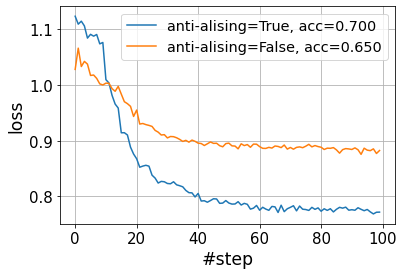

In [62]:
param,ret0 = load_result('82580623') #anti-aliasing=True, 94765250
param,ret1 = load_result('75154024') #anti-aliasing=False, 14556711
len_train_set = int(param['class_size']*2*0.8)
loss0 = np.array(ret0['loss_recorder'])/len_train_set
loss1 = np.array(ret1['loss_recorder'])/len_train_set
acc0 = ret0['test_accuracy']
acc1 = ret1['test_accuracy']

fig,ax = plt.subplots()
ax.plot(loss0, label=f'anti-alising=True, acc={acc0:.3f}')
ax.plot(loss1, label=f'anti-alising=False, acc={acc1:.3f}')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize='x-large')
ax.grid()
ax.set_xlabel('#step', fontsize='xx-large')
ax.set_ylabel('loss', fontsize='xx-large')
# fig.savefig('fig/draft20220209/QNN-compare-anti-alising.png', dpi=100)

`class_size=100` (total `200` samples)

| `anti_aliasing` | train-accuracy | test-accuracy |
| :-: | :-: | :-: |
| `True` | `0.775` | `0.7` |
| `False` | `0.656` | `0.65` |

conclusion: `anti_aliasing=True` is much better than `anti_aliasing=False`

### compare `ZZFeatureMap`, `Pauli`, `FRQI`

In [49]:
param = {'anti_aliasing':True, 'feature_type':'ZZ', 'normalize_max':np.pi/2}
param, train_accuracy, test_accuracy, loss_ZZ = QNN_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy, loss_recorder=loss_ZZ)

param = {'anti_aliasing':True, 'feature_type':'FRQI', 'normalize_max':np.pi/2}
param, train_accuracy, test_accuracy, loss_FRQI = QNN_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy, loss_recorder=loss_FRQI)

param = {'anti_aliasing':True, 'feature_type':'Pauli', 'normalize_max':np.pi/2}
param, train_accuracy, test_accuracy, loss_Pauli = QNN_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy, loss_recorder=loss_Pauli)

x_train_normed include 160 images, each of shape (4), range from 0.000 to 1.571
x_test_normed include 40 images, each of shape (4), range from 0.371 to 1.609
21 - 161.43762534213565
42 - 116.00746167406952
63 - 110.5637954744583
84 - 108.61808928224107
105 - 107.25548211558676
126 - 106.32599606388288
147 - 106.14579439606203
168 - 106.45191797018946
189 - 105.11484561196626
210 - 105.44964632149829
231 - 105.49479527979109
252 - 106.49009573565289
273 - 105.56382397891511
294 - 105.65735361546214
accuracy on the train set (size=160): 0.8125
accuracy on the test set (size=40) 0.775
result saved to "result/66876146.json"
x_train_normed include 160 images, each of shape (4), range from 0.000 to 1.571
x_test_normed include 40 images, each of shape (4), range from 0.371 to 1.609
21 - 155.02954307112424
42 - 153.71325685174008
63 - 154.47947805652825
84 - 154.01186076463605
105 - 153.57669501801308
126 - 153.32193949994704
147 - 152.07801355074267
168 - 152.77364921916856
189 - 152.83589171

'result/38594202.json'

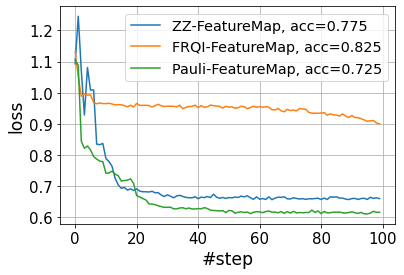

In [60]:
param,ret0 = load_result('66876146') #ZZFeatureMap
param,ret1 = load_result('94425977') #FRQI feature map
param,ret2 = load_result('38594202') #Pauli feature map
len_train_set = int(param['class_size']*2*0.8)
loss0 = np.array(ret0['loss_recorder'])/len_train_set
loss1 = np.array(ret1['loss_recorder'])/len_train_set
loss2 = np.array(ret2['loss_recorder'])/len_train_set
acc0 = ret0['test_accuracy']
acc1 = ret1['test_accuracy']
acc2 = ret2['test_accuracy']

fig,ax = plt.subplots()
ax.plot(loss0, label=f'ZZ-FeatureMap, acc={acc0:.3f}')
ax.plot(loss1, label=f'FRQI-FeatureMap, acc={acc1:.3f}')
ax.plot(loss2, label=f'Pauli-FeatureMap, acc={acc2:.3f}')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize='x-large')
ax.grid()
ax.set_xlabel('#step', fontsize='xx-large')
ax.set_ylabel('loss', fontsize='xx-large')
# fig.savefig('fig/draft20220209/QNN-compare-feature-map.png', dpi=100)

conclusion

| `FeatureMap` | train-accuracy | test-accuracy |
| :-: | :-: | :-: |
| `ZZ` | `0.812` | `0.775` |
| `FRQI` | `0.856` | `0.825` |
| `Pauli` | `0.85` | `0.725` |

1. `FRQI` outperforms than `ZZFeatureMap/PauliFeatureMap` on this dataset
2. lower loss doesn't always mean higher accuracy

### compare `resize_image_size`

x_train_normed include 160 images, each of shape (2), range from 0.000 to 1.571
x_test_normed include 40 images, each of shape (2), range from 0.284 to 1.548
21 - 154.31108653520806
42 - 151.6384726608907
63 - 150.16108636562467
84 - 150.1419496770768
105 - 149.3608251485815
126 - 149.44451333670204
147 - 147.812002232944
168 - 146.7526522516823
189 - 146.58014269291596
210 - 147.67216553521104
231 - 146.74656793998327
252 - 146.94133908180703
273 - 147.33799696901804
294 - 146.92009743633957
accuracy on the train set (size=160): 0.66875
accuracy on the test set (size=40) 0.7
result saved to "result/82843426.json"
x_train_normed include 160 images, each of shape (2), range from 0.000 to 1.571
x_test_normed include 40 images, each of shape (2), range from 0.482 to 1.559
21 - 113.30090017897476
42 - 99.47859903822781
63 - 94.38663018605406
84 - 89.53329564509428
105 - 88.25183620172527
126 - 89.10902155167548
147 - 88.97073790950314
168 - 88.87897963717609
189 - 89.37503529222144
210 - 8

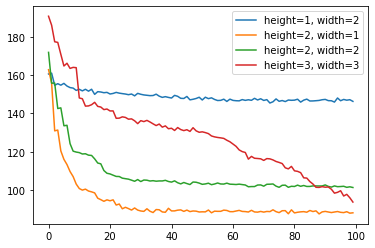

In [48]:
param = {'anti_aliasing':True, 'feature_dim':2, 'resize_image_size':(1,2), 'normalize_max':np.pi/2}
param, train_accuracy, test_accuracy, loss_1_2 = QNN_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy, loss_recorder=loss_1_2)

param = {'anti_aliasing':True, 'feature_dim':2, 'resize_image_size':(2,1), 'normalize_max':np.pi/2}
param, train_accuracy, test_accuracy, loss_2_1 = QNN_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy, loss_recorder=loss_2_1)
# this one diverge

param = {'anti_aliasing':True, 'feature_dim':4, 'resize_image_size':(2,2), 'normalize_max':np.pi/2}
param, train_accuracy, test_accuracy, loss_2_2 = QNN_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy, loss_recorder=loss_2_2)

param = {'anti_aliasing':True, 'feature_dim':9, 'resize_image_size':(3,3), 'normalize_max':np.pi/2}
param, train_accuracy, test_accuracy, loss_3_3 = QNN_all_in_one(param)
save_result(param=param, train_accuracy=train_accuracy, test_accuracy=test_accuracy, loss_recorder=loss_3_3)

# fig,ax = plt.subplots()
# ax.plot(loss_1_2, label='height=1, width=2')
# ax.plot(loss_2_1, label='height=2, width=1')
# ax.plot(loss_2_2, label='height=2, width=2')
# ax.plot(loss_3_3, label='height=3, width=3')
# ax.legend()

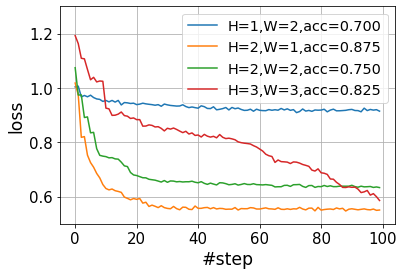

In [55]:
param,ret0 = load_result('82843426') #(1,2)
param,ret1 = load_result('44096990') #(2,1)
param,ret2 = load_result('38779382') #(2,2)
param,ret3 = load_result('18146346') #(3,3)
len_train_set = int(param['class_size']*2*0.8)
loss0 = np.array(ret0['loss_recorder'])/len_train_set
loss1 = np.array(ret1['loss_recorder'])/len_train_set
loss2 = np.array(ret2['loss_recorder'])/len_train_set
loss3 = np.array(ret3['loss_recorder'])/len_train_set
acc0 = ret0['test_accuracy']
acc1 = ret1['test_accuracy']
acc2 = ret2['test_accuracy']
acc3 = ret3['test_accuracy']

fig,ax = plt.subplots()
ax.plot(loss0, label=f'H=1,W=2,acc={acc0:.3f}')
ax.plot(loss1, label=f'H=2,W=1,acc={acc1:.3f}')
ax.plot(loss2, label=f'H=2,W=2,acc={acc2:.3f}')
ax.plot(loss3, label=f'H=3,W=3,acc={acc3:.3f}')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize='x-large')
ax.grid()
ax.set_ylim(0.5, 1.3)
ax.set_xlabel('#step', fontsize='xx-large')
ax.set_ylabel('loss', fontsize='xx-large')
# fig.savefig('fig/draft20220209/QNN-compare-resize-image.png', dpi=100)

the number of qubits `#qubit=height*width`

`class_size=100` (total `200` samples)

| `resize_image_size` | train-accuracy | test-accuracy |
| :-: | :-: | :-: |
| `(1,2)` | `0.668` | `0.7` |
| `(2,1)` | `0.906` | `0.875` |
| `(2,2)` | `0.837` | `0.75` |
| `(3,3)` | `0.831` | `0.825` |

conclusion:
1. model with more qubits might be better
2. lower loss doesn't always mean higher accurcy